# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of rows and columns, print the first few rows).

In [4]:
feat_info.head(5)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [5]:
print(f"number of features: {feat_info.shape[0]}")
print(f"information_level: {sorted(feat_info['information_level'].unique())}")
print(f"type: {sorted(feat_info['type'].unique())}")

number of features: 85
information_level: ['building', 'community', 'household', 'macrocell_plz8', 'microcell_rr3', 'microcell_rr4', 'person', 'postcode', 'region_rr1']
type: ['categorical', 'interval', 'mixed', 'numeric', 'ordinal']


In [6]:
azdias.head(5)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [7]:
print(f"number of people: {azdias.shape[0]}")

number of people: 891221


In [8]:
print(f"type occurences within the {feat_info.shape[0]} features:")
feat_info['type'].value_counts()

type occurences within the 85 features:


ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

In [9]:
feat_info.loc[feat_info['type'].isin(['mixed', 'interval'])]

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
43,ALTER_HH,household,interval,[0]
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1,0]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [10]:
print(f"datatype occurences within the {feat_info.shape[0]} features:")
for feat_dtype in azdias.dtypes.unique():
    print('-', feat_dtype, (azdias.dtypes == feat_dtype).sum())

features_dtype_object = azdias.dtypes[azdias.dtypes == 'object'].index.values
print(f"\nfeatures with object (not numeric) datatype: {features_dtype_object}")

datatype occurences within the 85 features:
- int64 32
- float64 49
- object 4

features with object (not numeric) datatype: ['OST_WEST_KZ' 'CAMEO_DEUG_2015' 'CAMEO_DEU_2015' 'CAMEO_INTL_2015']


In [11]:
print('nan and unique values of features with object (not numeric) dtype:')
for feat_name in features_dtype_object:
    print('-', feat_name, feat_info.loc[feat_info['attribute'] == feat_name, 'missing_or_unknown'].values[0], azdias[feat_name].unique())

nan and unique values of features with object (not numeric) dtype:
- OST_WEST_KZ [-1] [nan 'W' 'O']
- CAMEO_DEUG_2015 [-1,X] [nan '8' '4' '2' '6' '1' '9' '5' '7' '3' 'X']
- CAMEO_DEU_2015 [XX] [nan '8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C'
 '9C' '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F'
 '5F' '1C' 'XX']
- CAMEO_INTL_2015 [-1,XX] [nan '51' '24' '12' '43' '54' '22' '14' '13' '15' '33' '41' '34' '55' '25'
 '23' '31' '52' '35' '45' '44' '32' 'XX']


In [12]:
def get_nan_values(str_list: str) -> list[str]:
    return str_list[1:-1].split(',')

In [13]:
print('number of missing values per feature:')
feat_missing_values = {}
for idx, feat_record in feat_info.iterrows():
    feat_name = feat_record['attribute']
    nan_values = get_nan_values(str_list=feat_record['missing_or_unknown'])

    # real nan values and coded ones
    no_nan_values = azdias[feat_name].isna().sum() + azdias[feat_name].isin(nan_values).sum()

    feat_missing_values[feat_name] = no_nan_values

    if no_nan_values > 0:
        print(f"- feat{idx} {feat_name} has {no_nan_values} missing/unknown values")

number of missing values per feature:
- feat3 CJT_GESAMTTYP has 4854 missing/unknown values
- feat12 GFK_URLAUBERTYP has 4854 missing/unknown values
- feat15 LP_LEBENSPHASE_FEIN has 4854 missing/unknown values
- feat16 LP_LEBENSPHASE_GROB has 4854 missing/unknown values
- feat17 LP_FAMILIE_FEIN has 4854 missing/unknown values
- feat18 LP_FAMILIE_GROB has 4854 missing/unknown values
- feat19 LP_STATUS_FEIN has 4854 missing/unknown values
- feat20 LP_STATUS_GROB has 4854 missing/unknown values
- feat23 RETOURTYP_BK_S has 4854 missing/unknown values
- feat39 SOHO_KZ has 73499 missing/unknown values
- feat40 TITEL_KZ has 73499 missing/unknown values
- feat43 ALTER_HH has 73499 missing/unknown values
- feat44 ANZ_PERSONEN has 73499 missing/unknown values
- feat45 ANZ_TITEL has 73499 missing/unknown values
- feat46 HH_EINKOMMEN_SCORE has 18348 missing/unknown values
- feat47 KK_KUNDENTYP has 584612 missing/unknown values
- feat48 W_KEIT_KIND_HH has 107602 missing/unknown values
- feat49 WOHN

In [14]:
no_features_with_nan_values = 0
for no_nan_values in feat_missing_values.values():
    if no_nan_values > 0:
        no_features_with_nan_values += 1

print(f"there are {no_features_with_nan_values} features with any missing/unknown values")

there are 53 features with any missing/unknown values


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [15]:
no_nan_azdias = azdias.isna().sum().sum()

In [16]:
def conversion_type(values_list: list[str], feat_dtype: np.dtype) -> list:
    if feat_dtype.name == 'float64':
        return float
    elif feat_dtype.name == 'int64':
        return int
    else:
        return str

In [17]:
for idx, feat_name in enumerate(azdias.columns):
    nan_values = get_nan_values(str_list=feat_info.loc[feat_info['attribute'] == feat_name, 'missing_or_unknown'].values[0])
    if nan_values[0]:
        azdias[feat_name] = azdias[feat_name].replace(
            to_replace=list(map(conversion_type(values_list=nan_values, feat_dtype=azdias[feat_name].dtype), nan_values)),
            value=np.nan
            )

In [18]:
print(f"number of nan values before the conversion: {no_nan_azdias}")
print(f"number of nan values after the conversion: {azdias.isna().sum().sum()}")

number of nan values before the conversion: 4896838
number of nan values after the conversion: 8373929


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [19]:
# Perform an assessment of how much missing data there is in each column of the dataset.

no_nan_features = azdias.isna().sum()
no_nan_features

AGER_TYP                685843
ALTERSKATEGORIE_GROB      2881
ANREDE_KZ                    0
CJT_GESAMTTYP             4854
FINANZ_MINIMALIST            0
                         ...  
PLZ8_HHZ                116515
PLZ8_GBZ                116515
ARBEIT                   97375
ORTSGR_KLS9              97274
RELAT_AB                 97375
Length: 85, dtype: int64

In [20]:
# no_nan_features[no_nan_features > 0].sort_values(ascending=False)

In [21]:
prop_nan_features = (no_nan_features / azdias.shape[0]).sort_values(ascending=False)
prop_nan_features

TITEL_KZ        0.997576
AGER_TYP        0.769554
KK_KUNDENTYP    0.655967
KBA05_BAUMAX    0.534687
GEBURTSJAHR     0.440203
                  ...   
SEMIO_RAT       0.000000
SEMIO_KRIT      0.000000
SEMIO_DOM       0.000000
SEMIO_TRADV     0.000000
ZABEOTYP        0.000000
Length: 85, dtype: float64

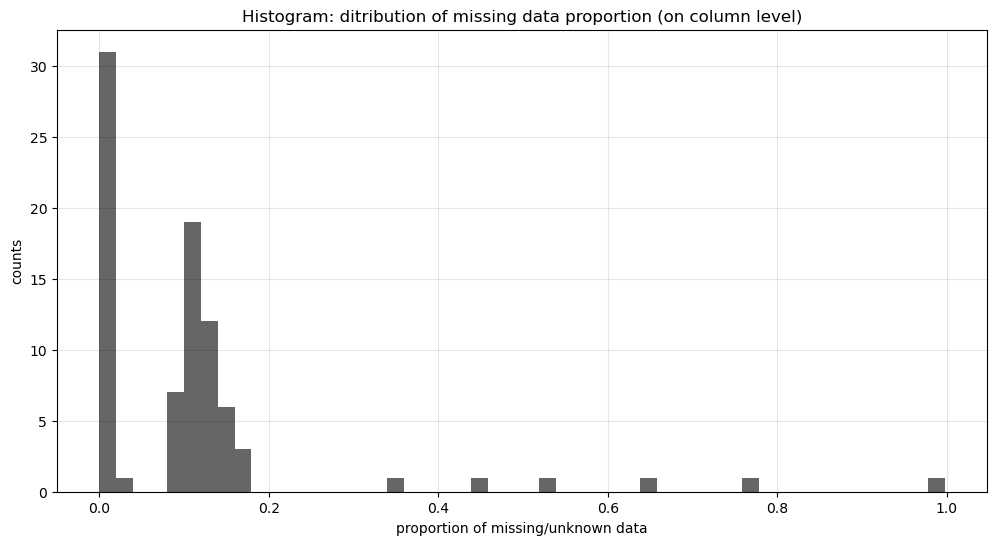

In [22]:
# Investigate patterns in the amount of missing data in each column.

plt.figure(figsize=(12,6))
plt.hist(prop_nan_features, bins=50, color='black', alpha=0.6);
plt.title('Histogram: ditribution of missing data proportion (on column level)')
plt.xlabel('proportion of missing/unknown data')
plt.ylabel('counts')
plt.grid(visible=True, color='black', alpha=0.1)

plt.show()

In [23]:
# Remove the outlier columns from the dataset. (You'll perform other data engineering tasks such as re-encoding and imputation later.)

prop_nan_threshold_col = 0.2
features_to_drop = prop_nan_features[prop_nan_features > prop_nan_threshold_col].index
features_to_drop

Index(['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR',
       'ALTER_HH'],
      dtype='object')

In [24]:
azdias.drop(features_to_drop, axis=1, inplace=True)

print(f"dropped {len(features_to_drop)} features with more than {int(prop_nan_threshold_col * 100)}% missing/unknown data")

dropped 6 features with more than 20% missing/unknown data


In [25]:
azdias.shape

(891221, 79)

#### Discussion 1.1.2: Assess Missing Data in Each Column

61 of the 85 initial features contained some missing/unknown values.

I chose a threshold based on the histogram: 0.2.

From these features, I found 6 outliers - *TITEL_KZ, AGER_TYP, KK_KUNDENTYP, KBA05_BAUMAX, GEBURTSJAHR, ALTER_HH* 
I dropped them because more than 20% of their data is missing.
I kept the other 79 features with missing values because they can be helpful later in clustering.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [26]:
# How much data is missing in each row of the dataset?

no_nan_records = azdias.isnull().sum(axis=1)
no_nan_records

0         43
1          0
2          0
3          7
4          0
          ..
891216     3
891217     4
891218     5
891219     0
891220     0
Length: 891221, dtype: int64

In [27]:
# Write code to divide the data into two subsets based on the number of missing values in each row.

prop_nan_records = (no_nan_records / azdias.shape[1])
prop_nan_records

0         0.544304
1         0.000000
2         0.000000
3         0.088608
4         0.000000
            ...   
891216    0.037975
891217    0.050633
891218    0.063291
891219    0.000000
891220    0.000000
Length: 891221, dtype: float64

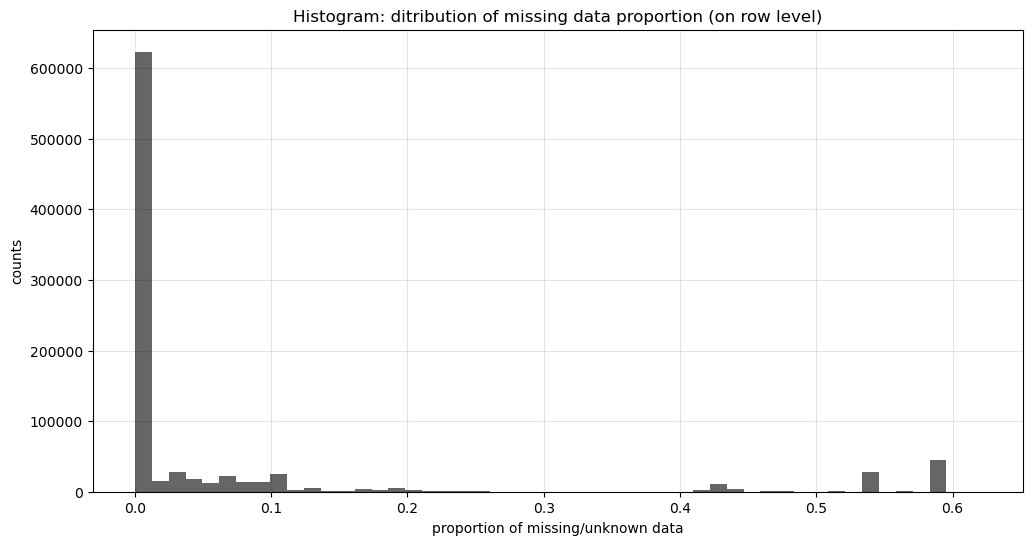

In [28]:
# Investigate patterns in the amount of missing data in each column.

plt.figure(figsize=(12,6))
plt.hist(prop_nan_records, bins=50, color='black', alpha=0.6);
plt.title('Histogram: ditribution of missing data proportion (on row level)')
plt.xlabel('proportion of missing/unknown data')
plt.ylabel('counts')
plt.grid(visible=True, color='black', alpha=0.1)

plt.show()

In [29]:
prop_nan_threshold_row = 0.3

records_below_th = azdias[prop_nan_records < prop_nan_threshold_row]
records_above_th = azdias[prop_nan_records >= prop_nan_threshold_row]

print(records_below_th.shape)
print(records_above_th.shape)

(797837, 79)
(93384, 79)


In [30]:
print(f"{(records_below_th.shape[0] / azdias.shape[0] * 100):.1f}% of the records have less than {int(prop_nan_threshold_row * 100)}% missing data")
print(f"{(records_above_th.shape[0] / azdias.shape[0] * 100):.1f}% of the records have more than {int(prop_nan_threshold_row * 100)}% missing data")

89.5% of the records have less than 30% missing data
10.5% of the records have more than 30% missing data


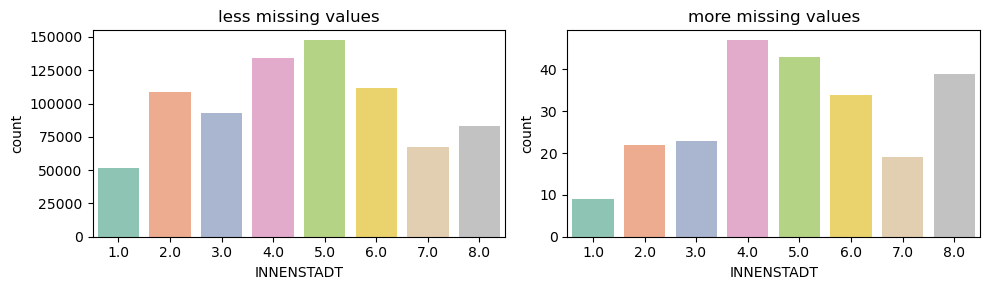

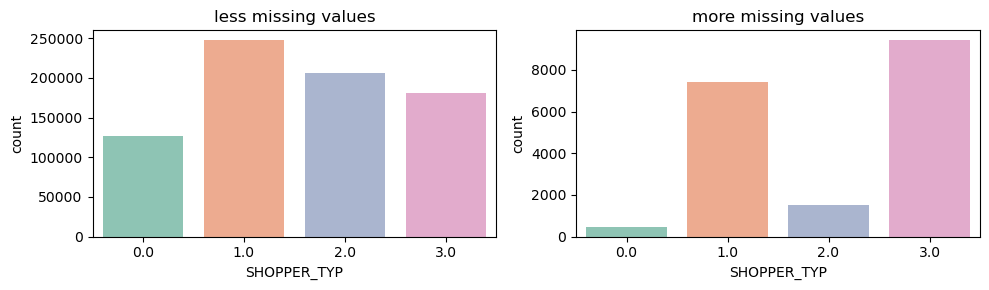

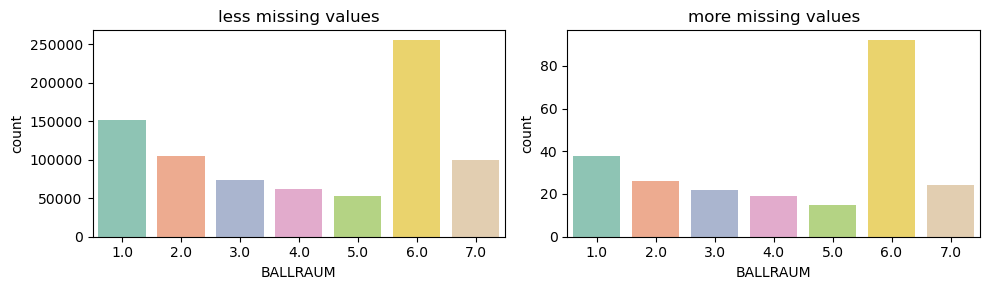

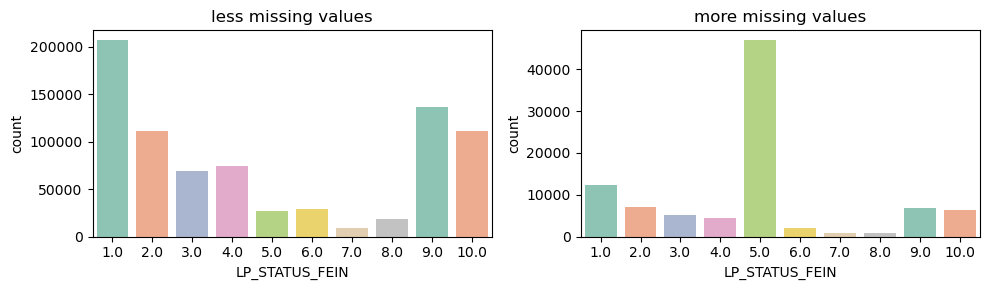

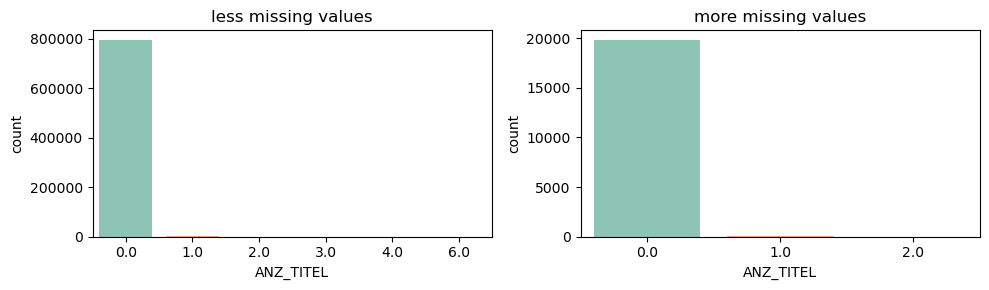

In [31]:
# Compare the distribution of values for at least five columns where there are no or few missing values, between the two subsets.

features_to_examine = pd.Series(azdias.columns).sample(n=5, random_state=7)
for feat_name in features_to_examine:
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))

    sns.countplot(ax=axs[0], x=feat_name, data=records_below_th, alpha=0.8, palette=sns.color_palette('Set2'))
    axs[0].set_title('less missing values')
    sns.countplot(ax=axs[1], x=feat_name, data=records_above_th, alpha=0.8, palette=sns.color_palette('Set2'))
    axs[1].set_title('more missing values')

    fig.tight_layout()

In [32]:
feat_info.loc[feat_info['attribute'].isin(features_to_examine), :]

,attribute,information_level,type,missing_or_unknown
19,LP_STATUS_FEIN,person,categorical,[0]
38,SHOPPER_TYP,person,categorical,[-1]
45,ANZ_TITEL,household,numeric,[]
66,BALLRAUM,postcode,ordinal,[-1]
68,INNENSTADT,postcode,ordinal,[-1]


In [33]:
records_to_drop = records_above_th.index
records_to_drop

Int64Index([     0,     11,     14,     17,     24,     30,     35,     46,
                48,     53,
            ...
            891100, 891130, 891137, 891140, 891159, 891164, 891171, 891175,
            891185, 891187],
           dtype='int64', length=93384)

In [34]:
azdias.drop(records_to_drop, axis=0, inplace=True)

print(f"dropped {len(records_to_drop)} records (with more than {int(prop_nan_threshold_row * 100)}% missing data)")

dropped 93384 records (with more than 30% missing data)


In [35]:
azdias.shape

(797837, 79)

#### Discussion 1.1.3: Assess Missing Data in Each Row

I chose a threshold based on the histogram: 0.3.

93384 of the 891221 initial records - 10.5% - contained significant amount of missing/unknown values. 89.5% of the initial records contained less or no missing/unknown values.
I compared these two groups and found that the distribution of the data on randomly selected columns may differ regarding some features but regarding others it is very similar.

- The distribution of the data regarding the two **categorical features** are distinct between the two examined groups: *SHOPPER_TYP, LP_STATUS_FEIN*
- The distribution of the data regarding the two **ordinal features** are very similar between the two groups: *BALLRAUM, INNENSTADT*
- The distribution of the data regarding the one **numeric feature** is consistent between the two groups: *ANZ_TITEL*

In the end I decided to drop all the records with more than 30% missing data.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [36]:
# How many features are there of each data type?

feat_info['type'].value_counts()

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [37]:
# Assess categorical variables: which are binary, which are multi-level, and which one needs to be re-encoded?

feat_cat = feat_info.loc[feat_info['type'] == 'categorical', 'attribute']
feat_cat = feat_cat[feat_cat.isin(azdias.columns)].values

In [38]:
feat_cat_nunique = azdias[feat_cat].nunique()

feat_cat_binary = feat_cat_nunique[feat_cat_nunique <= 2].index
feat_cat_multilevel = feat_cat_nunique[feat_cat_nunique > 2].index

In [39]:
print(f"there are {feat_cat.shape[0]} categorical features")
print(f"- {feat_cat_binary.shape[0]} from them are binary categoricals")
print(f"- {feat_cat_multilevel.shape[0]} from them are multi-level categoricals")

there are 18 categorical features
- 5 from them are binary categoricals
- 13 from them are multi-level categoricals


In [40]:
# Re-encode categorical binary variable(s) to be kept in the analysis.

feat_value_mapper = {}

for feat_name in feat_cat_binary:
    print(feat_name, azdias[feat_name].dtype, azdias[feat_name].unique())

    if azdias[feat_name].dtype == 'object':
        feat_values_unique = list(azdias[feat_name].unique())
        feat_value_mapper[feat_name] = {unique_value: feat_values_unique.index(unique_value) for unique_value in feat_values_unique}

        azdias[feat_name] = azdias[feat_name].map(feat_value_mapper[feat_name])

print("\nrecoded binary columns: ", feat_value_mapper)

ANREDE_KZ int64 [2 1]
GREEN_AVANTGARDE int64 [0 1]
SOHO_KZ float64 [1. 0.]
VERS_TYP float64 [ 2.  1. nan]
OST_WEST_KZ object ['W' 'O']

recoded binary columns:  {'OST_WEST_KZ': {'W': 0, 'O': 1}}


In [41]:
# Replace multi-level categoricals in azdias with their dummy encoded versions 

azdias_prev = azdias

azdias = pd.get_dummies(data=azdias_prev, columns=feat_cat_multilevel)

In [42]:
azdias_prev[sorted(feat_cat_multilevel)].head(5)

,CAMEO_DEUG_2015,CAMEO_DEU_2015,CJT_GESAMTTYP,FINANZTYP,GEBAEUDETYP,GFK_URLAUBERTYP,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,SHOPPER_TYP,ZABEOTYP
1,8,8A,5.0,1,8.0,10.0,5.0,3.0,2.0,1.0,1.0,3.0,5
2,4,4C,3.0,1,1.0,10.0,1.0,1.0,3.0,2.0,1.0,2.0,5
3,2,2A,2.0,6,1.0,1.0,NaN,NaN,9.0,4.0,1.0,1.0,3
4,6,6B,5.0,5,1.0,5.0,10.0,5.0,3.0,2.0,1.0,2.0,4
5,8,8C,2.0,2,1.0,1.0,1.0,1.0,4.0,2.0,1.0,0.0,4


In [43]:
feat_cat_multilevel_encoded = sorted(set(azdias.columns).difference(set(azdias_prev.columns)))

azdias[feat_cat_multilevel_encoded].head(5)

,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEU_2015_1A,...,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
5,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0


In [44]:
len(feat_cat_multilevel_encoded) == feat_cat_nunique[feat_cat_multilevel].sum()

True

In [45]:
azdias_prev.shape

(797837, 79)

In [46]:
azdias.shape

(797837, 194)

#### Discussion 1.2.1: Re-Encode Categorical Features

From 20 categorical features 4 are binary categoricals and 16 are multi-level categoricals.

I found 1 binary categorical feature which needed an encoding - *OST_WEST_KZ*

I encoded all the 16 multi-level categorical features with multiple dummy variables, so I got 146 variables and now I have 214 features.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [47]:
azdias = azdias.astype(float)

**PRAEGENDE_JUGENDJAHRE**

Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)

- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [48]:
azdias['PRAEGENDE_JUGENDJAHRE'].unique()

array([14., 15.,  8.,  3., 10., 11.,  5.,  9.,  6.,  4., nan,  2.,  1.,
       12., 13.,  7.])

In [49]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

decade_mapper = {1: 40, 2: 40, 3: 50, 4: 50, 5: 60, 6: 60, 7: 60, 8: 70, 9: 70, 10: 80, 11: 80, 12: 80, 13: 80, 14: 90, 15: 90}
mvmt_mapper = {1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0, 9: 1, 10: 0, 11: 1, 12: 0, 13: 1, 14: 0, 15: 1}

azdias['PRAEGENDE_JUGENDJAHRE_DECADE'] = azdias['PRAEGENDE_JUGENDJAHRE'].map(decade_mapper)
azdias['PRAEGENDE_JUGENDJAHRE_MVMT'] = azdias['PRAEGENDE_JUGENDJAHRE'].map(mvmt_mapper)

In [50]:
pd.concat([azdias['PRAEGENDE_JUGENDJAHRE'], azdias['PRAEGENDE_JUGENDJAHRE_DECADE'], azdias['PRAEGENDE_JUGENDJAHRE_MVMT']], axis=1).head(5)

,PRAEGENDE_JUGENDJAHRE,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MVMT
1,14.0,90.0,0.0
2,15.0,90.0,1.0
3,8.0,70.0,0.0
4,8.0,70.0,0.0
5,3.0,50.0,0.0


In [51]:
azdias.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)

**CAMEO_INTL_2015**

German CAMEO: Wealth / Life Stage Typology, mapped to international code

- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown

In [52]:
azdias['CAMEO_INTL_2015'].unique()

array([51., 24., 12., 43., 54., 22., 14., 13., 15., 33., 41., 34., 55.,
       nan, 25., 23., 31., 52., 35., 45., 44., 32.])

In [53]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
 
azdias['CAMEO_INTL_2015_WEALTH'] = azdias['CAMEO_INTL_2015'].apply(lambda r: r // 10)
azdias['CAMEO_INTL_2015_LIFE_STAGE'] = azdias['CAMEO_INTL_2015'].apply(lambda r: r % 10)

In [54]:
pd.concat([azdias['CAMEO_INTL_2015'], azdias['CAMEO_INTL_2015_WEALTH'], azdias['CAMEO_INTL_2015_LIFE_STAGE']], axis=1).head(15)

,CAMEO_INTL_2015,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
1,51.0,5.0,1.0
2,24.0,2.0,4.0
3,12.0,1.0,2.0
4,43.0,4.0,3.0
5,54.0,5.0,4.0
6,22.0,2.0,2.0
7,14.0,1.0,4.0
8,13.0,1.0,3.0
9,15.0,1.0,5.0
10,51.0,5.0,1.0


In [55]:
azdias.drop('CAMEO_INTL_2015', axis=1, inplace=True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

I created 4 new features.

From *PRAEGENDE_JUGENDJAHRE* I created *PRAEGENDE_JUGENDJAHRE_DECADE* and *PRAEGENDE_JUGENDJAHRE_MVMT* features with separating generation by decade and movement (mainstream vs. avantgarde).

From *CAMEO_INTL_2015* I created *CAMEO_INTL_2015_WEALTH* and *CAMEO_INTL_2015_LIFE_STAGES* features with breaking up the two-digit codes.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [56]:
# If there are other re-engineering tasks you need to perform, make sure you take care of them here. (Dealing with missing data will come in step 2.1.)

azdias.shape

(797837, 196)

In [57]:
(azdias.isna().sum() / len(azdias)).sort_values(ascending=False)

REGIOTYP                0.081117
KKK                     0.081117
W_KEIT_KIND_HH          0.074172
LP_LEBENSPHASE_FEIN     0.062682
LP_LEBENSPHASE_GROB     0.059072
                          ...   
LP_FAMILIE_FEIN_4.0     0.000000
LP_FAMILIE_FEIN_5.0     0.000000
LP_FAMILIE_FEIN_6.0     0.000000
LP_FAMILIE_FEIN_7.0     0.000000
LP_FAMILIE_FEIN_11.0    0.000000
Length: 196, dtype: float64

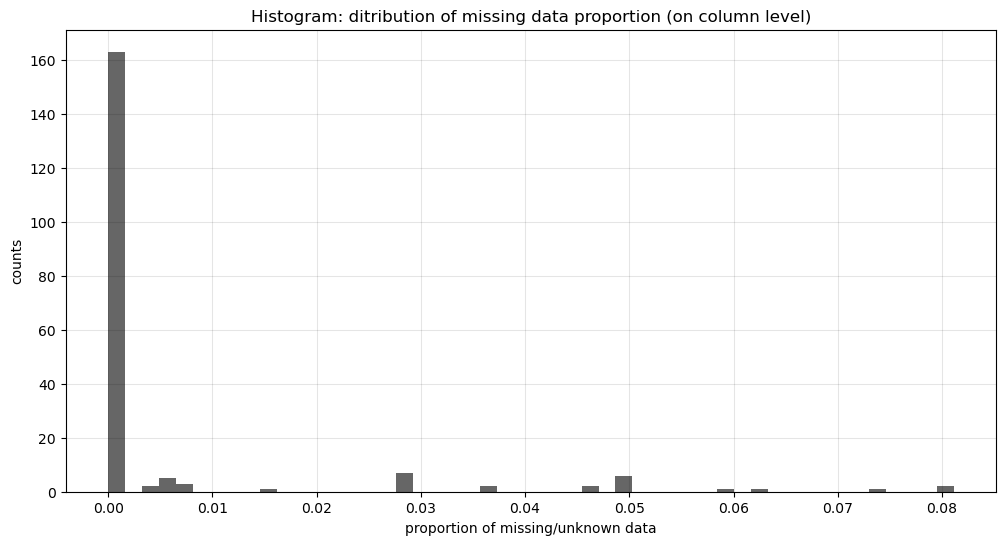

In [58]:
plt.figure(figsize=(12,6))
plt.hist(azdias.isna().sum() / len(azdias), bins=50, color='black', alpha=0.6);
plt.title('Histogram: ditribution of missing data proportion (on column level)')
plt.xlabel('proportion of missing/unknown data')
plt.ylabel('counts')
plt.grid(visible=True, color='black', alpha=0.1)

plt.show()

In [59]:
# Do whatever you need to in order to ensure that the dataframe only contains the columns that should be passed to the algorithm functions.

azdias.dtypes.unique()

array([dtype('float64')], dtype=object)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [60]:
def clean_data(df: pd.DataFrame, feat_info: pd.DataFrame, prop_nan_threshold_col: float = 0.2, prop_nan_threshold_row: float = 0.3):
    """
    Perform feature trimming, re-encoding, and engineering for demographics data
    
    INPUT: 
    - df: Demographics DataFrame
    - feat_info: Feature summary DataFrame
    - prop_nan_threshold_col: threshold for dropping features that missing data proportion is more than this value
    - prop_nan_threshold_row: threshold for dropping records that missing data proportion is more than this value
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """

    # convert missing/unknown data to np.nans

    for idx, feat_name in enumerate(df.columns):
        nan_values = get_nan_values(str_list=feat_info.loc[feat_info['attribute'] == feat_name, 'missing_or_unknown'].values[0])
        if nan_values[0]:
            df[feat_name] = df[feat_name].replace(
                to_replace=list(map(conversion_type(values_list=nan_values, feat_dtype=df[feat_name].dtype), nan_values)),
                value=np.nan
                )
    print('convert missing data to nan')

    # remove features that are missing a significant amount of data (based on prop_nan_threshold_col)

    no_nan_features = df.isna().sum()
    prop_nan_features = (no_nan_features / df.shape[0]).sort_values(ascending=False)

    features_to_drop = prop_nan_features[prop_nan_features > prop_nan_threshold_col].index
    df.drop(features_to_drop, axis=1, inplace=True)
    print(f"drop {len(features_to_drop)} features based on proportion threshold {prop_nan_threshold_col}")

    # remove records that are missing a significant amount of data (based on prop_nan_threshold_row)

    no_nan_records = df.isnull().sum(axis=1)
    prop_nan_records = (no_nan_records / df.shape[1])

    records_to_drop = df[prop_nan_records > prop_nan_threshold_row].index
    df.drop(records_to_drop, axis=0, inplace=True)
    print(f"drop {len(records_to_drop)} records based on proportion threshold {prop_nan_threshold_row}")

    # get categorical (binary and multi-level) features

    feat_cat = feat_info.loc[feat_info['type'] == 'categorical', 'attribute']
    feat_cat = feat_cat[feat_cat.isin(df.columns)].values

    feat_cat_nunique = df[feat_cat].nunique()
    feat_cat_binary = feat_cat_nunique[feat_cat_nunique <= 2].index
    feat_cat_multilevel = feat_cat_nunique[feat_cat_nunique > 2].index

    # handle binary categorical features

    feat_value_mapper = {}

    for feat_name in feat_cat_binary:

        if df[feat_name].dtype == 'object':
            feat_values_unique = list(df[feat_name].unique())
            feat_value_mapper[feat_name] = {unique_value: feat_values_unique.index(unique_value) for unique_value in feat_values_unique}

            df[feat_name] = df[feat_name].map(feat_value_mapper[feat_name])

    print(f"handle {len(feat_value_mapper.keys())} binary categorical features")

    # handle multi-level categorical features
    
    df = pd.get_dummies(data=df, columns=feat_cat_multilevel)
    print(f"handle {len(feat_cat_multilevel)} multi-level categorical features")

    # convert all feature values to floats

    df = df.astype(float)

    # engineer mixed-type features: PRAEGENDE_JUGENDJAHRE, CAMEO_INTL_2015

    decade_mapper = {1: 40, 2: 40, 3: 50, 4: 50, 5: 60, 6: 60, 7: 60, 8: 70, 9: 70, 10: 80, 11: 80, 12: 80, 13: 80, 14: 90, 15: 90}
    mvmt_mapper = {1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0, 9: 1, 10: 0, 11: 1, 12: 0, 13: 1, 14: 0, 15: 1}

    if 'PRAEGENDE_JUGENDJAHRE' in df.columns:
        print('create new features PRAEGENDE_JUGENDJAHRE_DECADE, PRAEGENDE_JUGENDJAHRE_MVMT from PRAEGENDE_JUGENDJAHRE.')
        df['PRAEGENDE_JUGENDJAHRE_DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].map(decade_mapper)
        df['PRAEGENDE_JUGENDJAHRE_MVMT'] = df['PRAEGENDE_JUGENDJAHRE'].map(mvmt_mapper)
        df.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)

    if 'CAMEO_INTL_2015' in df.columns:
        print('create new features CAMEO_INTL_2015_WEALTH, CAMEO_INTL_2015_LIFE_STAGE from CAMEO_INTL_2015.')
        df['CAMEO_INTL_2015_WEALTH'] = df['CAMEO_INTL_2015'].apply(lambda r: r // 10)
        df['CAMEO_INTL_2015_LIFE_STAGE'] = df['CAMEO_INTL_2015'].apply(lambda r: r % 10)
        df.drop('CAMEO_INTL_2015', axis=1, inplace=True)

    return df

In [61]:
# Load in the general demographics data.
data = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

# Test cleaning function
data = clean_data(df=data, feat_info=feat_info)

convert missing data to nan
drop 6 features based on proportion threshold 0.2
drop 93384 records based on proportion threshold 0.3
handle 1 binary categorical features
handle 13 multi-level categorical features
create new features PRAEGENDE_JUGENDJAHRE_DECADE, PRAEGENDE_JUGENDJAHRE_MVMT from PRAEGENDE_JUGENDJAHRE.
create new features CAMEO_INTL_2015_WEALTH, CAMEO_INTL_2015_LIFE_STAGE from CAMEO_INTL_2015.


In [62]:
assert data.shape == azdias.shape, 'clean_data() is not working properly'

True

In [62]:
data.shape

(797837, 196)

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [63]:
data_cols = data.columns

In [64]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and do that now.

from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')

data = imputer.fit_transform(X=data)

In [65]:
np.isnan(data).sum()

0

In [66]:
data = pd.DataFrame(data)
data.columns = data_cols

In [67]:
# Apply feature scaling to the general population demographics data.

from sklearn.preprocessing import StandardScaler 

scaler = StandardScaler()

data_scaled = scaler.fit_transform(X=data)

In [68]:
data.mean(axis=1)

0         16.729592
1         15.290816
2         14.605179
3         13.989796
4         18.204082
            ...    
797832    13.084344
797833    14.733250
797834    15.257243
797835    12.627551
797836    15.209184
Length: 797837, dtype: float64

In [69]:
data_scaled.mean(axis=1)

array([ 0.09573139, -0.03502689, -0.09532887, ..., -0.05617953,
        0.07250246, -0.06783124])

In [70]:
data_scaled = pd.DataFrame(data_scaled)
data_scaled.columns = data_cols

### Discussion 2.1: Apply Feature Scaling

I filled in all the missing values with the average of the given feature - for this task I used *SimpleImputer()* which replaces the previous Imputer from sklearn version 0.20.

I scaled all the features to have a mean 0 and standard deviation 1 - for this task I used *StandardScaler()*.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [71]:
def show_scree_plot(pca, cumulative: bool = True, n_components: bool = None) -> None:
    pca_components = np.arange(pca.n_components_)
    var_explained = pca.explained_variance_ratio_
    cumulative_var_explained = np.cumsum(var_explained)

    plt.figure(figsize=(12, 6))

    plt.bar(pca_components[:n_components], var_explained[:n_components], color='black', alpha=0.6)
    if cumulative:
        plt.plot(pca_components[:n_components], cumulative_var_explained[:n_components], color='black')
    plt.title('Explained variance ratio per principal component')
    plt.xlabel('principal component')
    plt.ylabel('explained variance ratio')
    plt.grid(visible=True, color='black', alpha=0.1)

    plt.show();

In [72]:
# Apply PCA to the data.

from sklearn.decomposition import PCA

pca_initial = PCA()

pca_initial_results = pca_initial.fit_transform(X=data_scaled)

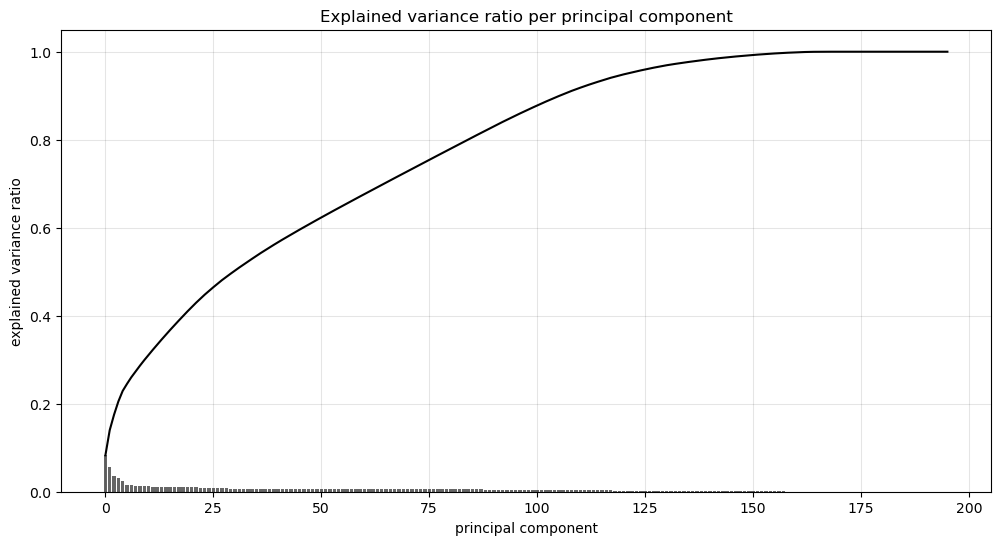

In [73]:
# Investigate the variance accounted for by each principal component.

show_scree_plot(pca=pca_initial)

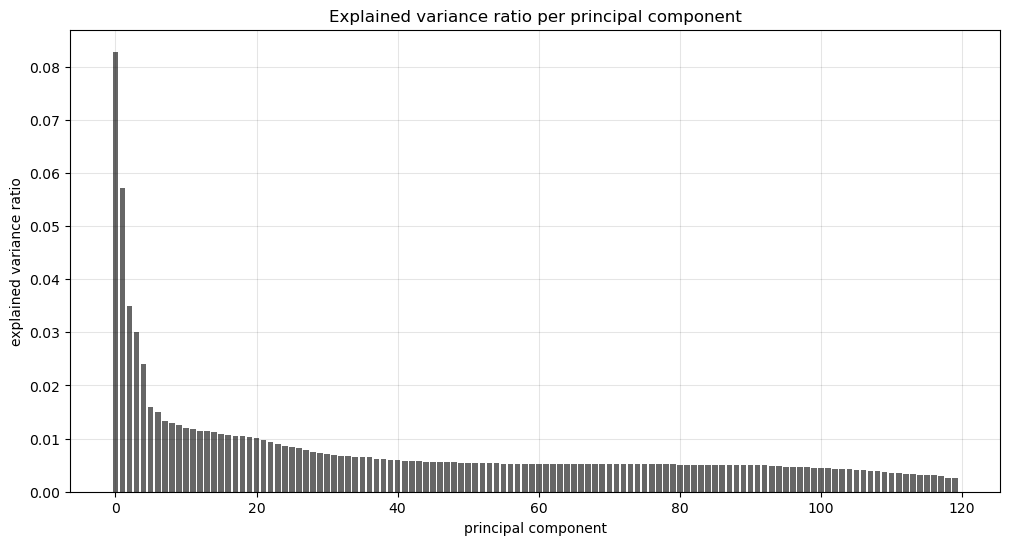

In [74]:
show_scree_plot(pca=pca_initial, cumulative=False, n_components=120)

In [75]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca_calibrated = PCA(n_components=80)

pca_results = pca_calibrated.fit_transform(X=data_scaled)

In [76]:
pca_calibrated.explained_variance_ratio_.sum()

0.771249355499953

In [77]:
data_scaled.shape

(797837, 196)

### Discussion 2.2: Perform Dimensionality Reduction

Initially I ran the PCA() with all the principal components to see how it performs.

Based on the scree plot I decided to use the first 80 components, which explain 77% of the variance. It is significantly less than 196, the number of features after all the preprocessing steps.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [78]:
# HINT: Try defining a function here or in a new cell that you can reuse in the other cells.

def get_pca_feature_weights(pca, features: list, n: int, absolute: bool = False) -> pd.Series:
    pca_components = pd.DataFrame(pca.components_, columns=features)

    if absolute:
        pca_components = abs(pca_components)

    feature_weights = pca_components.iloc[n].sort_values(ascending=False)
    
    return feature_weights

In [79]:
# Map weights for the first principal component to corresponding feature names and then print the linked values, sorted by weight.

weights_pc0 = get_pca_feature_weights(pca=pca_calibrated, features=data_cols, n=0)
weights_pc0

LP_STATUS_GROB_1.0        0.188834
HH_EINKOMMEN_SCORE        0.180171
CAMEO_INTL_2015_WEALTH    0.179896
PLZ8_ANTG3                0.179268
PLZ8_ANTG4                0.174080
                            ...   
KBA05_GBZ                -0.176888
FINANZ_MINIMALIST        -0.179236
PLZ8_ANTG1               -0.179925
KBA05_ANTG1              -0.186272
MOBI_REGIO               -0.199326
Name: 0, Length: 196, dtype: float64

In [80]:
# Map weights for the second principal component to corresponding feature names and then print the linked values, sorted by weight.

weights_pc1 = get_pca_feature_weights(pca=pca_calibrated, features=data_cols, n=1)
weights_pc1

ALTERSKATEGORIE_GROB            0.237422
FINANZ_VORSORGER                0.223478
ZABEOTYP_3                      0.199195
SEMIO_ERL                       0.180917
SEMIO_LUST                      0.166012
                                  ...   
SEMIO_TRADV                    -0.210523
FINANZ_UNAUFFAELLIGER          -0.217090
SEMIO_REL                      -0.217786
FINANZ_SPARER                  -0.234117
PRAEGENDE_JUGENDJAHRE_DECADE   -0.241691
Name: 1, Length: 196, dtype: float64

In [81]:
# Map weights for the third principal component to corresponding feature names and then print the linked values, sorted by weight.

weights_pc2 = get_pca_feature_weights(pca=pca_calibrated, features=data_cols, n=2)
weights_pc2

SEMIO_VERT     0.314848
SEMIO_FAM      0.255882
SEMIO_SOZ      0.254283
SEMIO_KULT     0.247366
FINANZTYP_5    0.136967
                 ...   
SEMIO_ERL     -0.205887
SEMIO_KRIT    -0.265110
SEMIO_DOM     -0.275260
SEMIO_KAEM    -0.307708
ANREDE_KZ     -0.339249
Name: 2, Length: 196, dtype: float64

In [82]:
pca_weights = pd.concat([weights_pc0, weights_pc1, weights_pc2], axis=1)

In [83]:
pca_weights_abs = pd.concat(
    [get_pca_feature_weights(pca=pca_calibrated, features=data_cols, n=0, absolute=True),
     get_pca_feature_weights(pca=pca_calibrated, features=data_cols, n=1, absolute=True),
     get_pca_feature_weights(pca=pca_calibrated, features=data_cols, n=2, absolute=True)],
    axis=1)

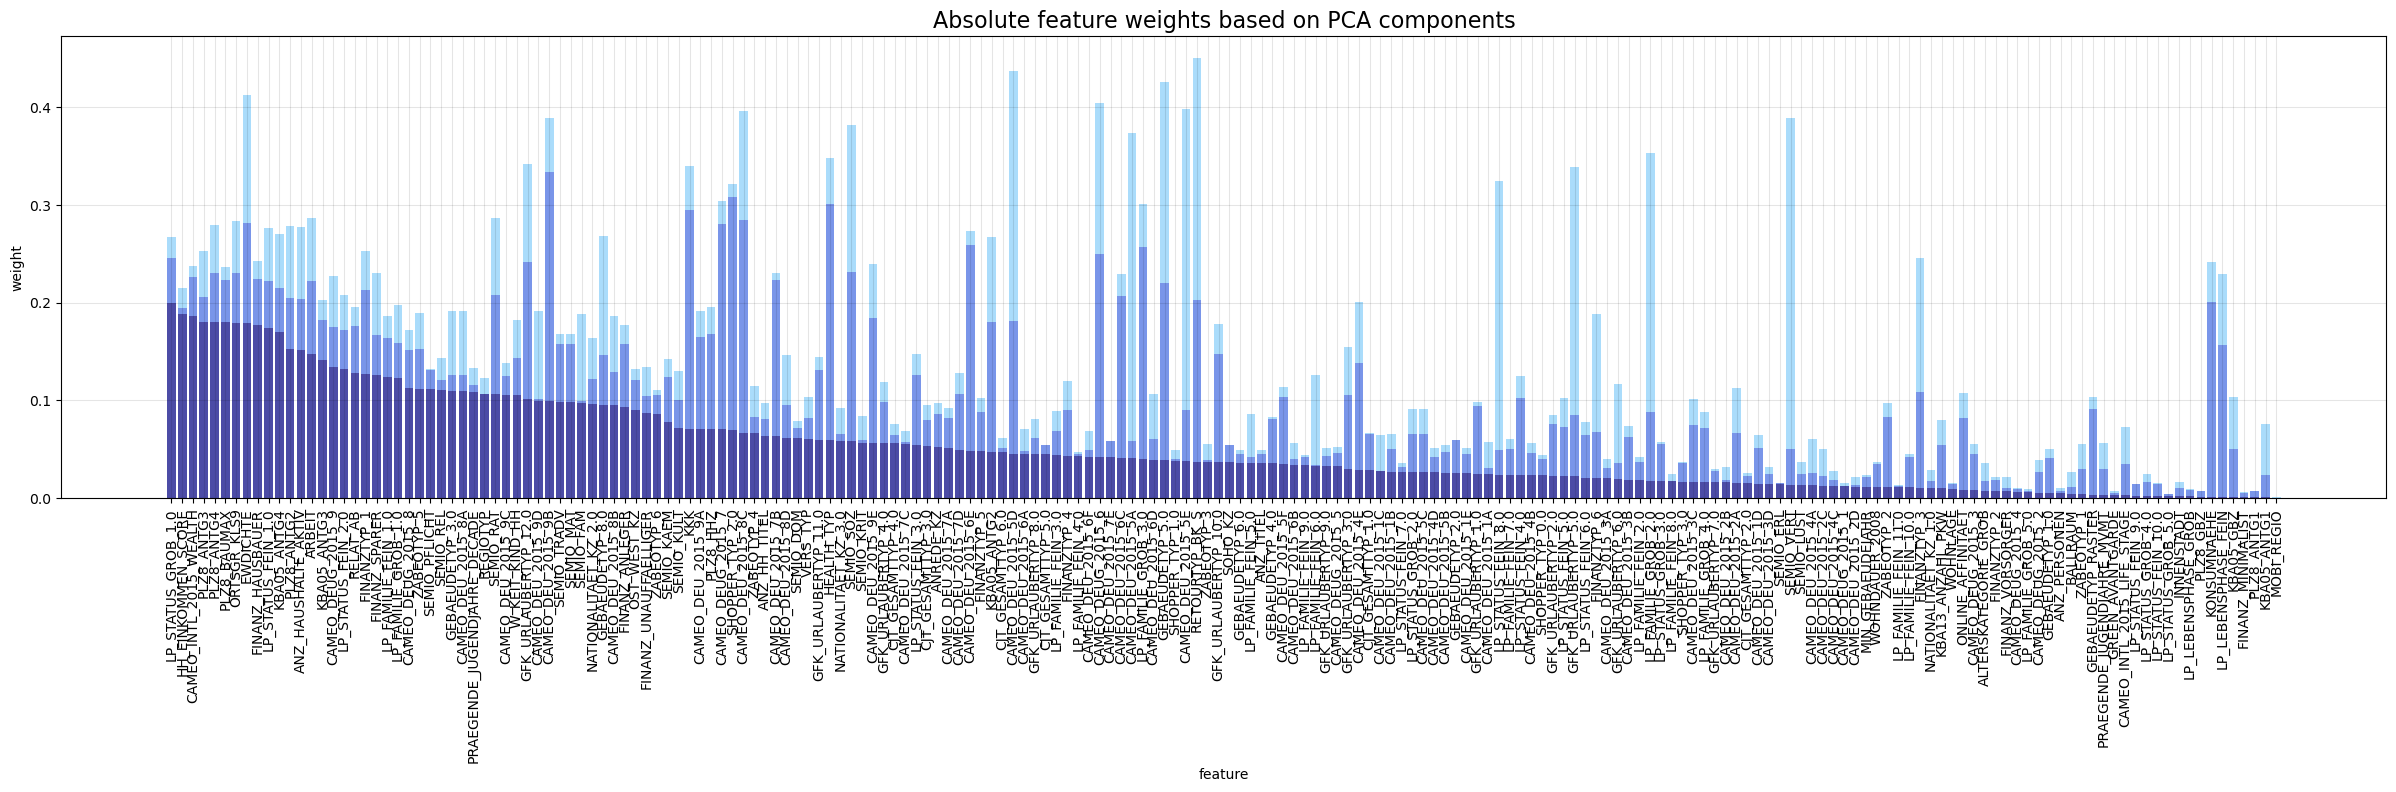

In [84]:
plt.figure(figsize=(30, 6))

plt.bar(pca_weights.index, pca_weights_abs[0], color='navy', alpha=0.7)
plt.bar(pca_weights.index, pca_weights_abs[1], bottom=pca_weights_abs[0], color='royalblue', alpha=0.7)
plt.bar(pca_weights.index, pca_weights_abs[2], bottom=(pca_weights_abs[1]+pca_weights_abs[0]), color='lightskyblue', alpha=0.7)

plt.title('Absolute feature weights based on PCA components', fontsize=16)
plt.xlabel('feature')
plt.ylabel('weight')
plt.xticks(rotation=90)
plt.grid(visible=True, color='black', alpha=0.1)

plt.show();

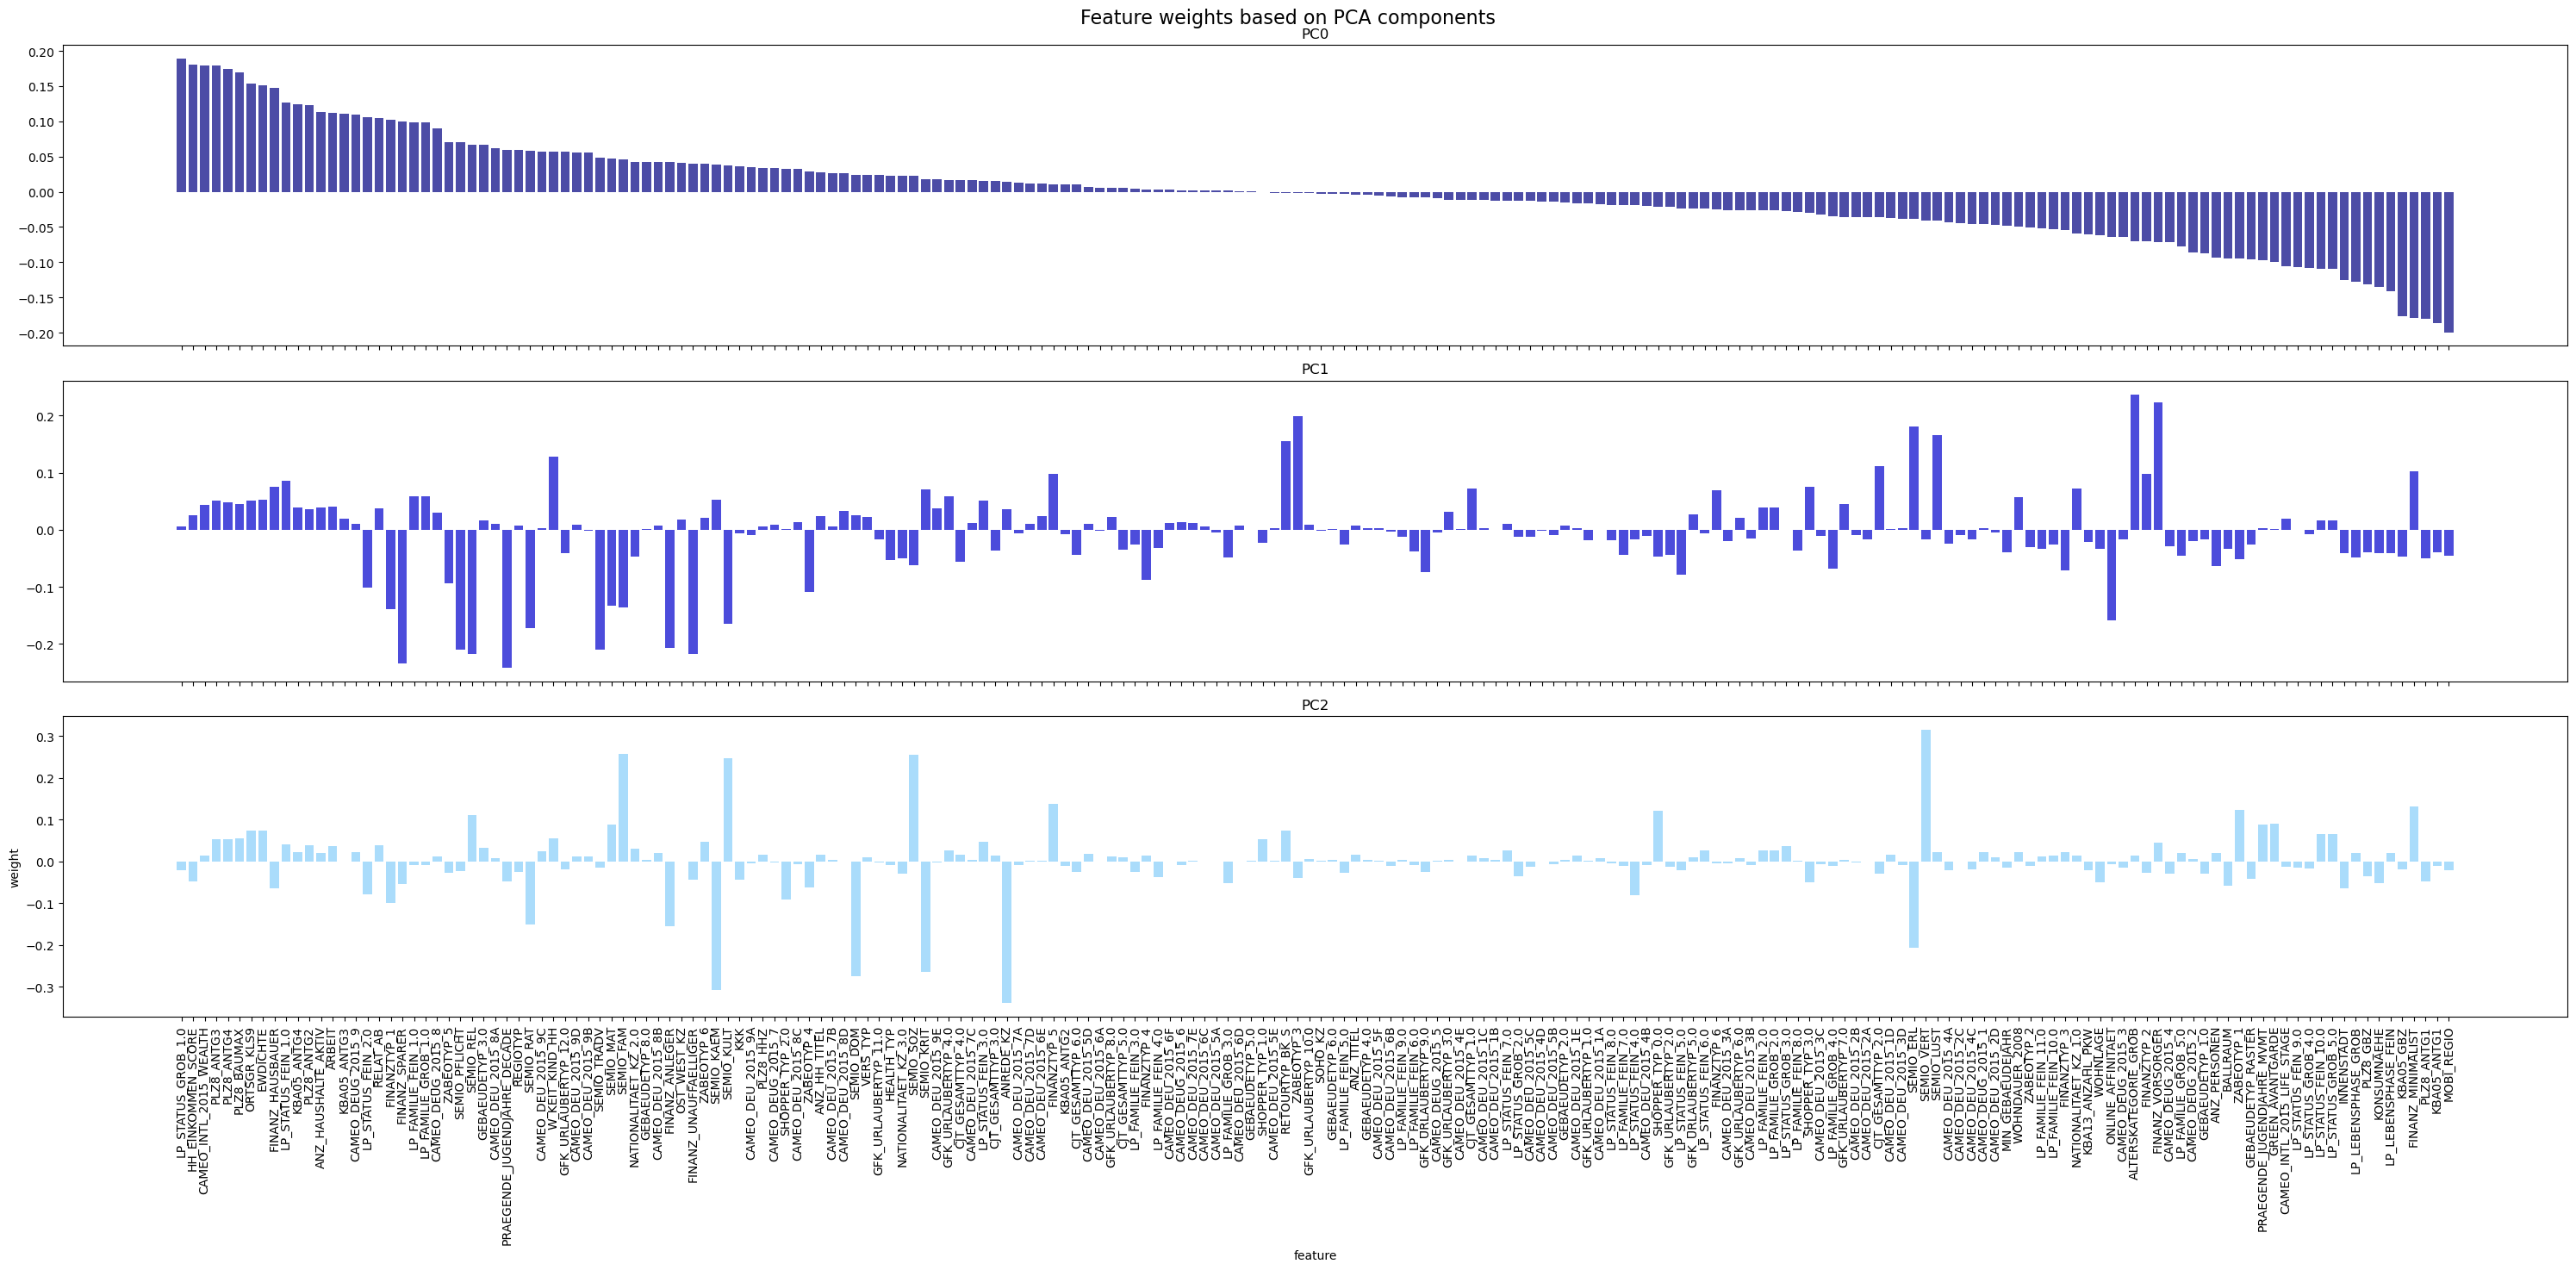

In [85]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(30, 15), sharex=True)

fig.suptitle('Feature weights based on PCA components', fontsize=16)

axs[0].bar(pca_weights.index, pca_weights[0], color='navy', alpha=0.7)
axs[0].set_title('PC0')
axs[1].bar(pca_weights.index, pca_weights[1], color='mediumblue', alpha=0.7)
axs[1].set_title('PC1')
axs[2].bar(pca_weights.index, pca_weights[2], color='lightskyblue', alpha=0.7)
axs[2].set_title('PC2')

plt.xlabel('feature')
plt.ylabel('weight')
plt.xticks(rotation=90)

fig.tight_layout()

plt.show();

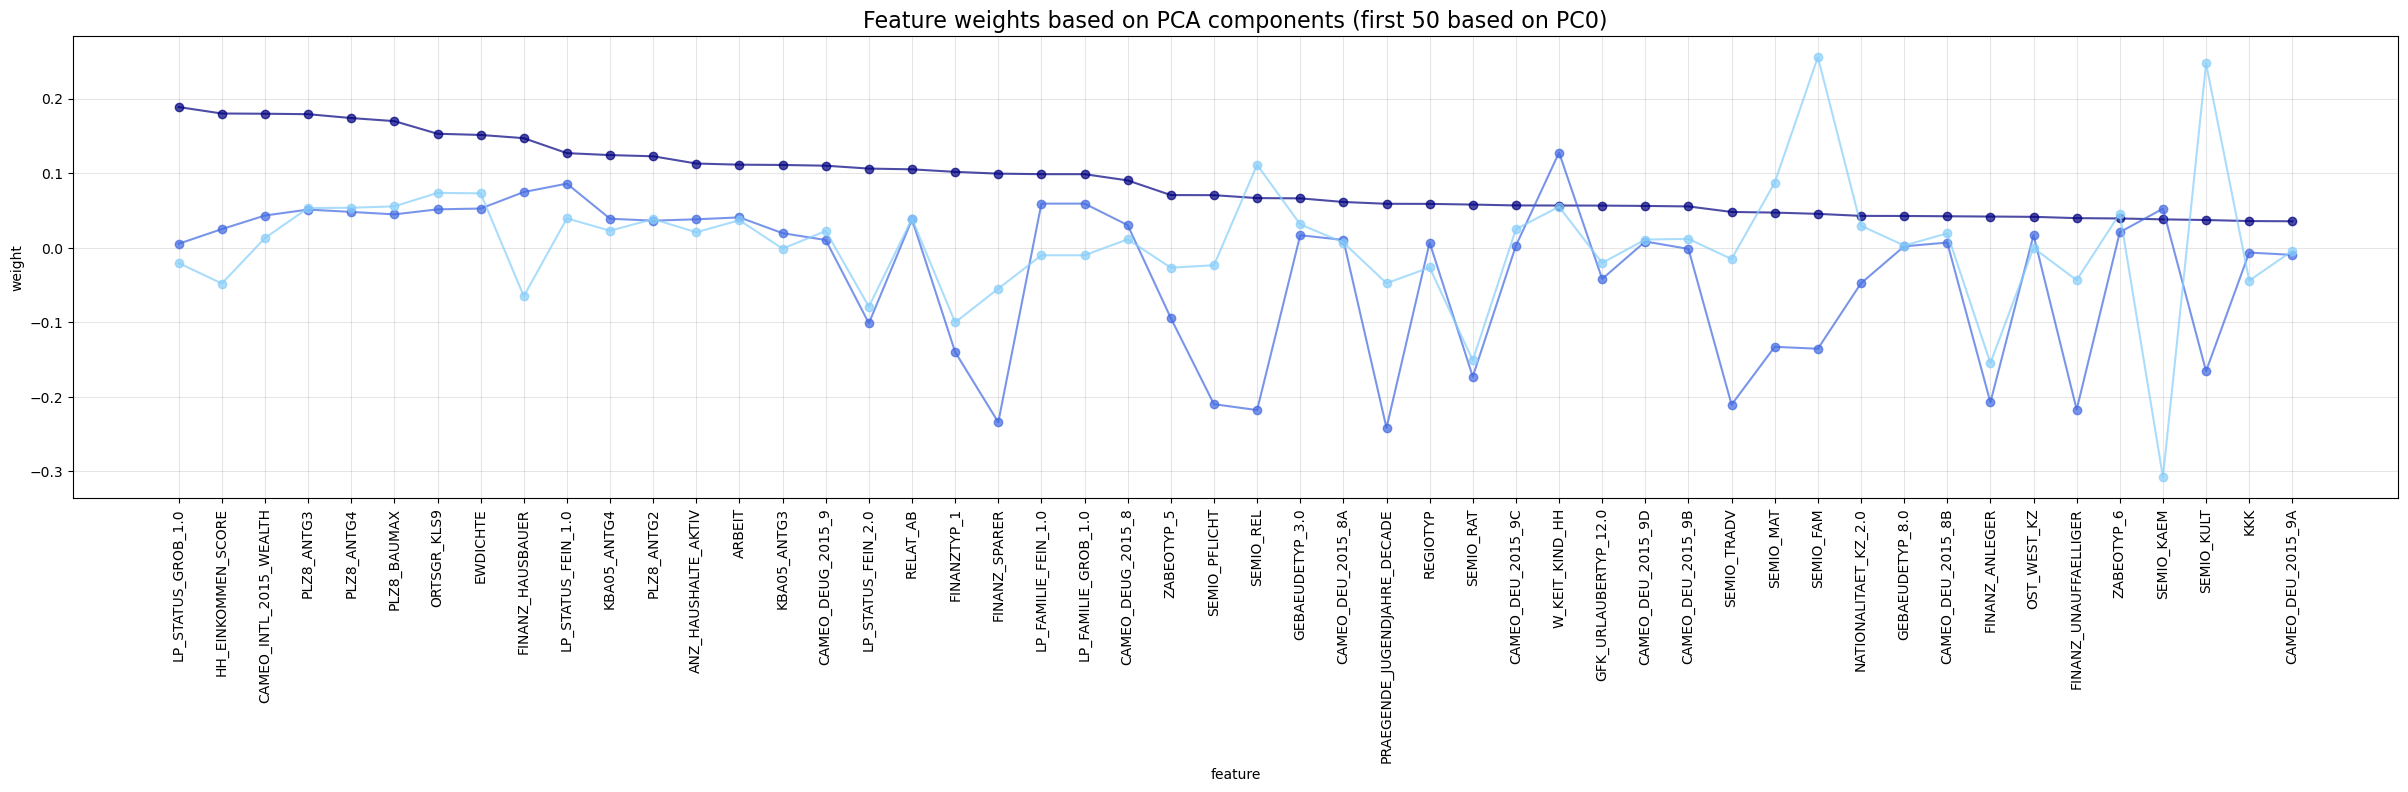

In [ ]:
plt.figure(figsize=(30, 6))

pca_weights_plot = pca_weights.copy()
pca_weights_plot = pd.concat([pca_weights_plot.iloc[:10], pca_weights_plot.iloc[-10:]], axis=1)

plt.plot(pca_weights_plot.index, pca_weights_plot[0], marker='o', color='navy', alpha=0.7)
plt.plot(pca_weights_plot.index, pca_weights_plot[1], marker='o', color='royalblue', alpha=0.7)
plt.plot(pca_weights_plot.index, pca_weights_plot[2], marker='o', color='lightskyblue', alpha=0.7)

plt.title('Feature weights based on PCA components (first and last 10 based on PC0)', fontsize=16)
plt.xlabel('feature')
plt.ylabel('weight')
plt.xticks(rotation=90)
plt.grid(visible=True, color='black', alpha=0.1)

plt.show();

### Discussion 2.3: Interpret Principal Components

I examined the feature weights of the first 3 principal components.

The **first principal component** mostly correlates positively with features *LP_STATUS_GROB_1.0, HH_EINKOMMEN_SCORE, CAMEO_INTL_2015_WEALTH* and negatively with *MOBI_REGIO, KBA05_ANTG1, PLZ8_ANTG1*. Regarding magnitude the first principal component mostly correlates with MOBI_REGIO.

The **second principal component** mostly correlates positively with features *ALTERSKATEGORIE_GROB, FINANZ_VORSORGER, ZABEOTYP_3* and negatively with *PRAEGENDE_JUGENDJAHRE_DECADE, FINANZ_SPARER, SEMIO_REL*. Regarding magnitude the first principal component mostly correlates with *PRAEGENDE_JUGENDJAHRE_DECADE*.

The **third principal component** mostly correlates positively with features *SEMIO_VERT, SEMIO_FAM, SEMIO_SOZ* and negatively with *ANREDE_KZ, SEMIO_KAEM, SEMIO_DOM*. Regarding magnitude the first principal component mostly correlates with *ANREDE_KZ*.

I think positive and negative correlations can be both helpful for us in interpreting the feature weights of the principal components.

2 of the 4 features I created from mixed-type variables appear here.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [88]:
from sklearn.cluster import KMeans

# Over a number of different cluster counts
n_clusters_list = [*list(range(3, 15, 2)), *list(range(15, 35, 5))]
scores = []

for n_clusters in n_clusters_list:
    print(f"n_clusters={n_clusters}")

    # run k-means clustering on the data and
    kmeans_initial = KMeans(n_clusters=n_clusters)
    kmeans_initial.fit(X=pca_results)

    # compute the average within-cluster distances
    scores.append(np.abs(kmeans_initial.score(X=pca_results)))

n_clusters=3
n_clusters=5
n_clusters=7
n_clusters=9
n_clusters=11
n_clusters=13
n_clusters=15
n_clusters=20
n_clusters=25
n_clusters=30


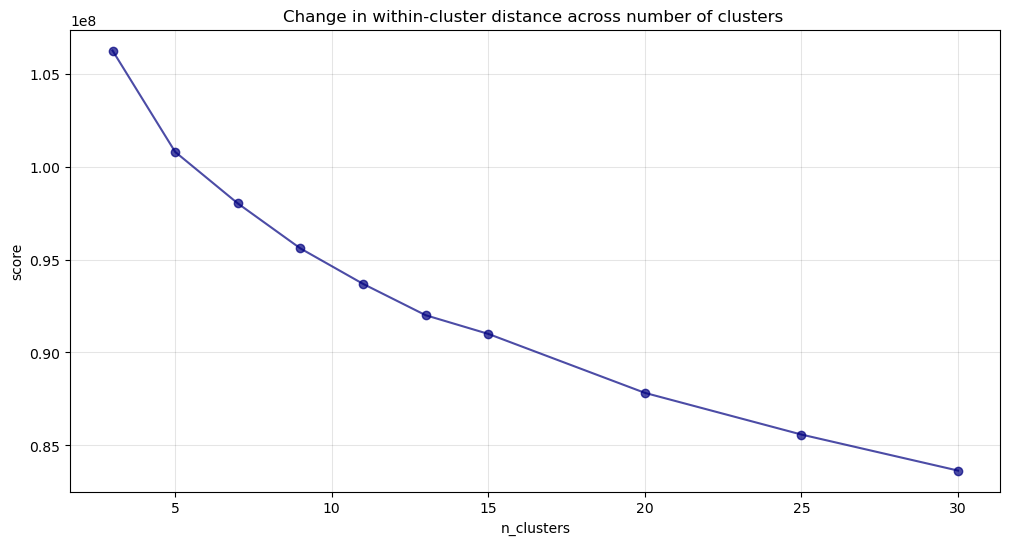

In [89]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.figure(figsize=(12, 6))

plt.plot(n_clusters_list, scores, marker='o', color='navy', alpha=0.7)

plt.title('Change in within-cluster distance across number of clusters ')
plt.xlabel('n_clusters')
plt.ylabel('score')
plt.grid(visible=True, color='black', alpha=0.1)

plt.show();

In [90]:
# Re-fit the k-means model with the selected number of clusters and obtain cluster predictions for the general population demographics data.

kmeans_calibrated = KMeans(n_clusters=25)
kmeans_calibrated.fit(X=pca_results)

cluster_predictions = kmeans_calibrated.predict(X=pca_results)

### Discussion 3.1: Apply Clustering to General Population

Based on the elbow plot I decided to segment the population into 25 clusters.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [96]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [97]:
# preprocessing

customers = clean_data(df=customers, feat_info=feat_info)

convert missing data to nan
drop 53 features based on proportion threshold 0.2
drop 0 records based on proportion threshold 0.3
handle 0 binary categorical features
handle 6 multi-level categorical features


In [98]:
# add all the features present in demographic data to customer data to make it compatible with scaling, fill these additional features with 0 values

customer_cols = customers.columns
cols_to_add = list(set(data_cols).difference(set(customer_cols)))

customers_ext = pd.concat(
    [customers,
     pd.DataFrame(columns=cols_to_add, index=customers.index).fillna(0)],
    axis=1
    )
customers_ext = customers_ext[data_cols]

In [99]:
# na handling

customers_ext = imputer.transform(X=customers_ext)

customers_ext = pd.DataFrame(customers_ext)
customers_ext.columns = data_cols

In [100]:
# scaling

customers_scaled = scaler.transform(X=customers_ext)

customers_scaled = pd.DataFrame(customers_scaled)
customers_scaled.columns = data_cols

In [101]:
# feature transformation

pca_results_customers = pca_calibrated.transform(X=customers_scaled)

In [102]:
# clustering

cluster_predictions_customers = kmeans_calibrated.predict(X=pca_results_customers)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [118]:
cluster_prop = pd.concat(
    [pd.Series(cluster_predictions).value_counts() / len(cluster_predictions),
     pd.Series(cluster_predictions_customers).value_counts() / len(cluster_predictions_customers)],
    axis=1
    ).fillna(0)
cluster_prop.columns = ['demographics', 'customer']
cluster_prop['cluster'] = cluster_prop.index

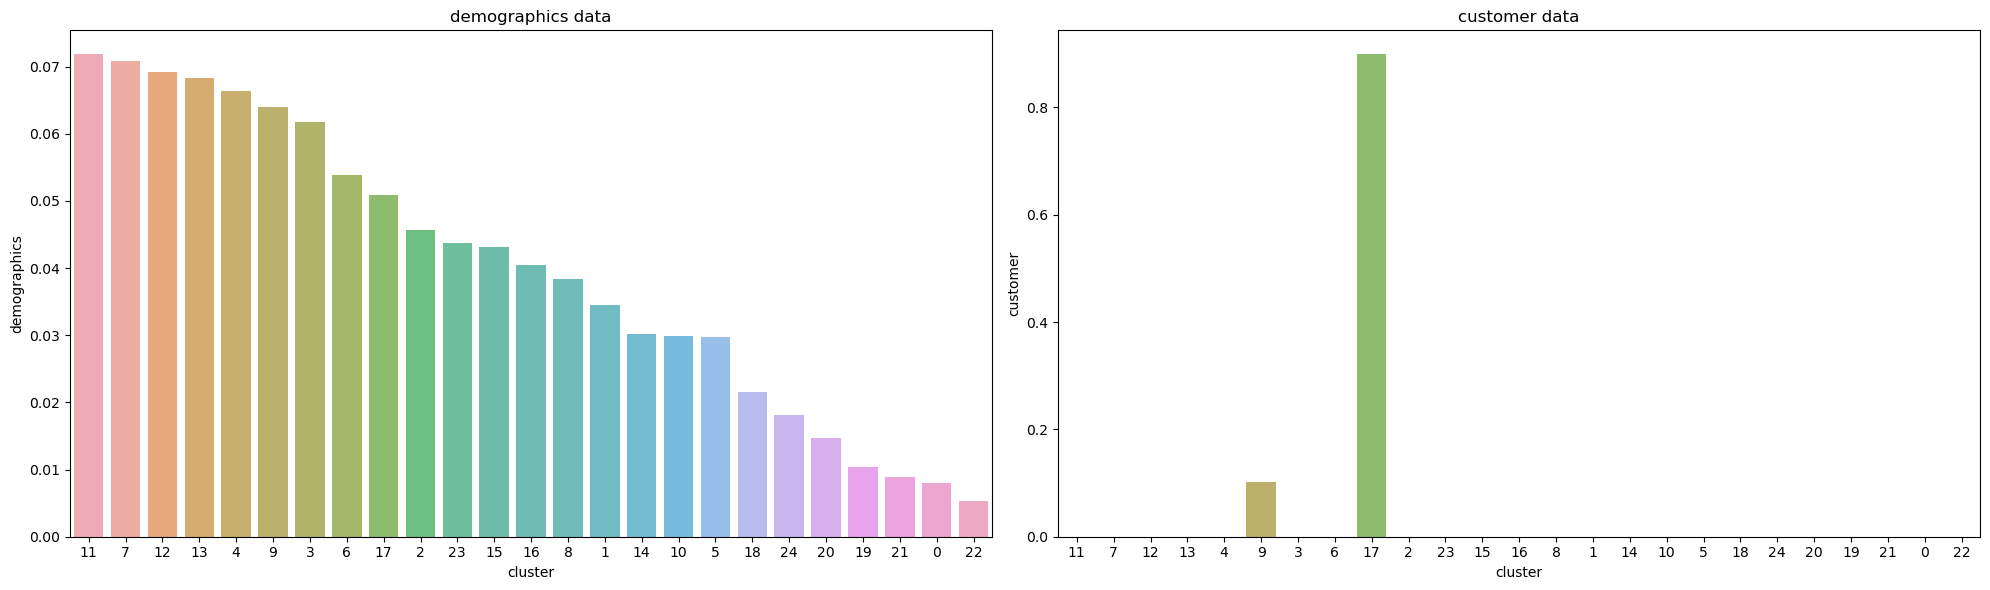

In [122]:
# Compare the proportion of data in each cluster for the customer data to the proportion of data in each cluster for the general population.

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

sns.barplot(ax=axs[0], data=cluster_prop, x='cluster', y='demographics', order=cluster_prop.index,  alpha=0.8)
axs[0].set_title('demographics data')
sns.barplot(ax=axs[1], data=cluster_prop, x='cluster', y='customer', order=cluster_prop.index, alpha=0.8)
axs[1].set_title('customer data')

fig.tight_layout()

In [123]:
# What kinds of people are part of a cluster that is overrepresented in the customer data compared to the general population?

cluster_n = 17

cluster_overrepr = pd.Series(
    data=scaler.inverse_transform(X=pca_calibrated.inverse_transform(X=kmeans_calibrated.cluster_centers_[cluster_n]).reshape(1, -1)).reshape(-1,),
    index=data_cols
    )

print(f"cluster overrepresented - cluster{cluster_n}:")
print(cluster_overrepr.head(10))

cluster overrepresented - cluster17:
ALTERSKATEGORIE_GROB     3.271892
ANREDE_KZ                1.396969
FINANZ_MINIMALIST        3.353872
FINANZ_SPARER            1.747987
FINANZ_VORSORGER         4.238203
FINANZ_ANLEGER           1.382950
FINANZ_UNAUFFAELLIGER    2.125016
FINANZ_HAUSBAUER         3.770877
GREEN_AVANTGARDE         0.456219
HEALTH_TYP               2.151246
dtype: float64


In [128]:
# What kinds of people are part of a cluster that is underrepresented in the customer data compared to the general population?

cluster_n = 11

cluster_underrepr = pd.Series(
    data=scaler.inverse_transform(X=pca_calibrated.inverse_transform(X=kmeans_calibrated.cluster_centers_[cluster_n]).reshape(1, -1)).reshape(-1,),
    index=data_cols
    )

print(f"cluster underrepresented - cluster{cluster_n}::")
print(cluster_underrepr.head(10))

cluster underrepresented - cluster11::
ALTERSKATEGORIE_GROB     1.796011
ANREDE_KZ                0.950721
FINANZ_MINIMALIST        1.834920
FINANZ_SPARER            4.528556
FINANZ_VORSORGER         1.902337
FINANZ_ANLEGER           3.685726
FINANZ_UNAUFFAELLIGER    3.962905
FINANZ_HAUSBAUER         3.627239
GREEN_AVANTGARDE         0.091010
HEALTH_TYP               2.314374
dtype: float64


In [129]:
((cluster_underrepr[customer_cols] - customers[customer_cols].mean()) / (customers[customer_cols].std())).sort_values(ascending=False).head(10)

LP_STATUS_FEIN_2.0      4.960812
ZABEOTYP_5              4.919171
FINANZTYP_1             3.882515
LP_STATUS_GROB_1.0      2.417689
SEMIO_KULT              2.087889
FINANZ_SPARER           1.873173
HH_EINKOMMEN_SCORE      1.672812
SEMIO_TRADV             1.652354
SEMIO_SOZ               1.650642
GFK_URLAUBERTYP_12.0    1.627139
dtype: float64

In [126]:
cluster_features = pd.concat([cluster_overrepr, cluster_underrepr], axis=1)
cluster_features['diff'] = abs(cluster_features[0] - cluster_features[1])
cluster_features = cluster_features.sort_values(by='diff', ascending=False)

In [127]:
cluster_features.head(10)

,0,1,diff
KBA13_ANZAHL_PKW,567.477924,680.306938,112.829015
PRAEGENDE_JUGENDJAHRE_DECADE,65.388908,85.292178,19.903270
LP_LEBENSPHASE_FEIN,13.373388,23.711855,10.338467
ANZ_HAUSHALTE_AKTIV,9.392599,1.846172,7.546426
MIN_GEBAEUDEJAHR,1992.352593,1998.224463,5.871870
LP_LEBENSPHASE_GROB,3.745849,7.169023,3.423174
ORTSGR_KLS9,7.183714,3.777466,3.406248
FINANZ_HAUSBAUER,3.770877,0.928483,2.842394
EWDICHTE,5.339510,2.799264,2.540246
SEMIO_LUST,5.209793,2.827812,2.381981


### Discussion 3.3: Compare Customer Data to Demographics Data

Based on the countplots there is a significant difference between the proportion of people in the demographics data and people in the customer data.

I see one slightly and one highly **over-represented** cluster in the customer population - cluster 9 and 17.
- **Cluster 9** covers 10% of the customer data, but only 0.6% of the demographics data.
- **Cluster 17** covers 90% of the customer data, but only 5% of the demographics data. People belonging to this cluster are highly over-represented in the company's customer base. The majority of these people are money-savers who are older, than 46.

All the other clusters are **under-represented** in the customer population.
- One under-represented cluster is **cluster 11**, which covers 72% of the general population. People belonging to this cluster are under-represented in the company's customer base. The majority of these people are males, younger, than 46 who have low financial interests.

There are some huge differences between cluster 17 (over-represented) and cluster 11 (under-represented).
- While the over-represented cluster includes mostly single top earners of higher age and average-earner couples, the under-represented cluster consist of low-income and average-earner families. - *LP_LEBENSPHASE_FEIN, LP_LEBENSPHASE_GROB*
- Number of households in the building is higher in the over-represented cluster. - *ANZ_HAUSHALTE_AKTIV*
- Size of the community is 10 times higher within the over-represented cluster. - *ORTSGR_KLS9*
- While the under-represented cluster includes homeowners, number of homeowners in the over-represented cluster is much lower. - *FINANZ_HAUSBAUER*

I would recommend the company to focus more on people who belong to an over-represented group - cluster 17 - and ignore heavily under-represented groups - e.g cluster 11 -.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.